# Section 2: YOLO-World for New Logo Detection

This notebook uses YOLO-World, a zero-shot object detection model that can detect objects based on text descriptions without training.

## YOLO-World Overview:
- **Zero-shot Detection**: Can detect objects from text prompts without training
- **Advantages**: 
  - No fine-tuning needed for new classes
  - Works with text descriptions
  - Fast inference
  - Good for open-vocabulary detection
- **Use Case**: Perfect for detecting new logos by describing them in text


In [1]:
# Import necessary libraries
import os
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check device (MPS for Mac M1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


Using device: mps


## 1. Load Section 2 Data


Image size: (2500, 2340)
New classes to detect: ['adidas', 'nba_national_basketball_association', 'miami_heat']


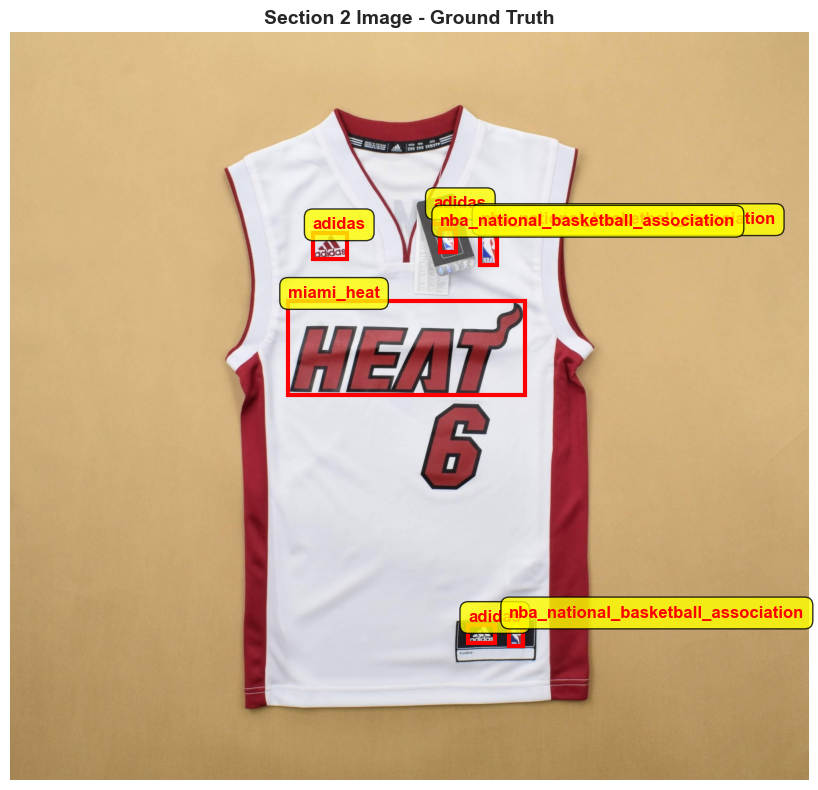

In [2]:
# Load Section 2 data
SECTION2_ROOT = Path("raw_data/logos-dataset-section-2")
section2_image = SECTION2_ROOT / "Adidas_38.jpg"
section2_label = SECTION2_ROOT / "Adidas_38.txt"

# Load image
img = Image.open(section2_image)
print(f"Image size: {img.size}")

# Load annotations to get class names
with open(section2_label, 'r') as f:
    annotations = f.readlines()

new_classes = []
for ann in annotations:
    parts = ann.strip().split()
    if len(parts) >= 5:
        class_name = parts[0]
        if class_name not in new_classes:
            new_classes.append(class_name)

print(f"New classes to detect: {new_classes}")

# Visualize ground truth
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img)
ax.axis('off')
ax.set_title('Section 2 Image - Ground Truth', fontsize=14, fontweight='bold')

img_width, img_height = img.size
for ann in annotations:
    parts = ann.strip().split()
    if len(parts) >= 5:
        class_name = parts[0]
        x_center, y_center, width, height = [float(x) for x in parts[1:5]]
        x = (x_center - width/2) * img_width
        y = (y_center - height/2) * img_height
        w = width * img_width
        h = height * img_height
        
        from matplotlib.patches import Rectangle
        rect = Rectangle((x, y), w, h, linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y-10, class_name, color='red', fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

plt.tight_layout()
plt.savefig('section2_yolo_world_ground_truth.png', dpi=300, bbox_inches='tight')
plt.show()


## 2. Install and Setup YOLO-World


In [3]:
# Install YOLO-World
try:
    from ultralytics import YOLO
    # Check if YOLO-World is available
    print("Ultralytics installed")
except ImportError:
    print("Installing ultralytics...")
    import subprocess
    subprocess.check_call(["pip", "install", "ultralytics"])
    from ultralytics import YOLO

# YOLO-World models: yolov8s-world.pt, yolov8m-world.pt, yolov8l-world.pt, yolov8x-world.pt
# Try to load YOLO-World model
try:
    print("Loading YOLO-World model...")
    # YOLO-World uses text prompts for zero-shot detection
    model = YOLO('yolov8s-world.pt')  # Small model for faster inference
    print("YOLO-World model loaded successfully!")
except Exception as e:
    print(f"YOLO-World model not available: {e}")
    print("Note: YOLO-World may require specific ultralytics version")
    print("Alternative: Using standard YOLO with custom prompts")
    model = YOLO('yolov8s.pt')
    print("Using standard YOLO as fallback")


Ultralytics installed
Loading YOLO-World model...
YOLO-World model loaded successfully!


## 3. Zero-Shot Detection with Text Prompts


In [4]:
# Set custom vocabulary for YOLO-World
# YOLO-World can detect objects based on text descriptions
custom_vocabulary = new_classes.copy()

# Add some variations and synonyms for better detection
vocab_expansions = {
    'adidas': ['adidas logo', 'adidas brand', 'three stripes'],
    'nba': ['nba logo', 'nba basketball', 'national basketball association'],
    'miami_heat': ['miami heat logo', 'miami heat', 'heat logo']
}

expanded_vocab = []
for cls in custom_vocabulary:
    expanded_vocab.append(cls)
    if cls.lower() in vocab_expansions:
        expanded_vocab.extend(vocab_expansions[cls.lower()])

print(f"Custom vocabulary: {custom_vocabulary}")
print(f"Expanded vocabulary: {expanded_vocab[:10]}...")

# Set custom vocabulary (if YOLO-World supports it)
try:
    # YOLO-World API may vary - try different methods
    if hasattr(model, 'set_classes'):
        model.set_classes(custom_vocabulary)
        print("Set custom classes using set_classes()")
    elif hasattr(model, 'set_vocabulary'):
        model.set_vocabulary(custom_vocabulary)
        print("Set custom vocabulary using set_vocabulary()")
    else:
        print("Note: Setting custom vocabulary may require specific YOLO-World API")
        print("Proceeding with standard detection...")
except Exception as e:
    print(f"Could not set custom vocabulary: {e}")
    print("Proceeding with standard detection...")


Custom vocabulary: ['adidas', 'nba_national_basketball_association', 'miami_heat']
Expanded vocabulary: ['adidas', 'adidas logo', 'adidas brand', 'three stripes', 'nba_national_basketball_association', 'miami_heat', 'miami heat logo', 'miami heat', 'heat logo']...
requirements: Ultralytics requirement ['git+https://github.com/ultralytics/CLIP.git'] not found, attempting AutoUpdate...
WARNING ⚠️ Retry 1/2 failed: Command 'pip install --no-cache-dir "git+https://github.com/ultralytics/CLIP.git" ' returned non-zero exit status 127.
WARNING ⚠️ Retry 2/2 failed: Command 'pip install --no-cache-dir "git+https://github.com/ultralytics/CLIP.git" ' returned non-zero exit status 127.
WARNING ⚠️ requirements: ❌ Command 'pip install --no-cache-dir "git+https://github.com/ultralytics/CLIP.git" ' returned non-zero exit status 127.
Could not set custom vocabulary: No module named 'clip'
Proceeding with standard detection...


Running YOLO-World zero-shot detection...
Looking for: ['adidas', 'nba_national_basketball_association', 'miami_heat']

image 1/1 /Users/yanivz/Documents/code/sports/logo/logos_detector/raw_data/logos-dataset-section-2/Adidas_38.jpg: 608x640 (no detections), 157.5ms
Speed: 5.3ms preprocess, 157.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)

No objects detected by YOLO-World


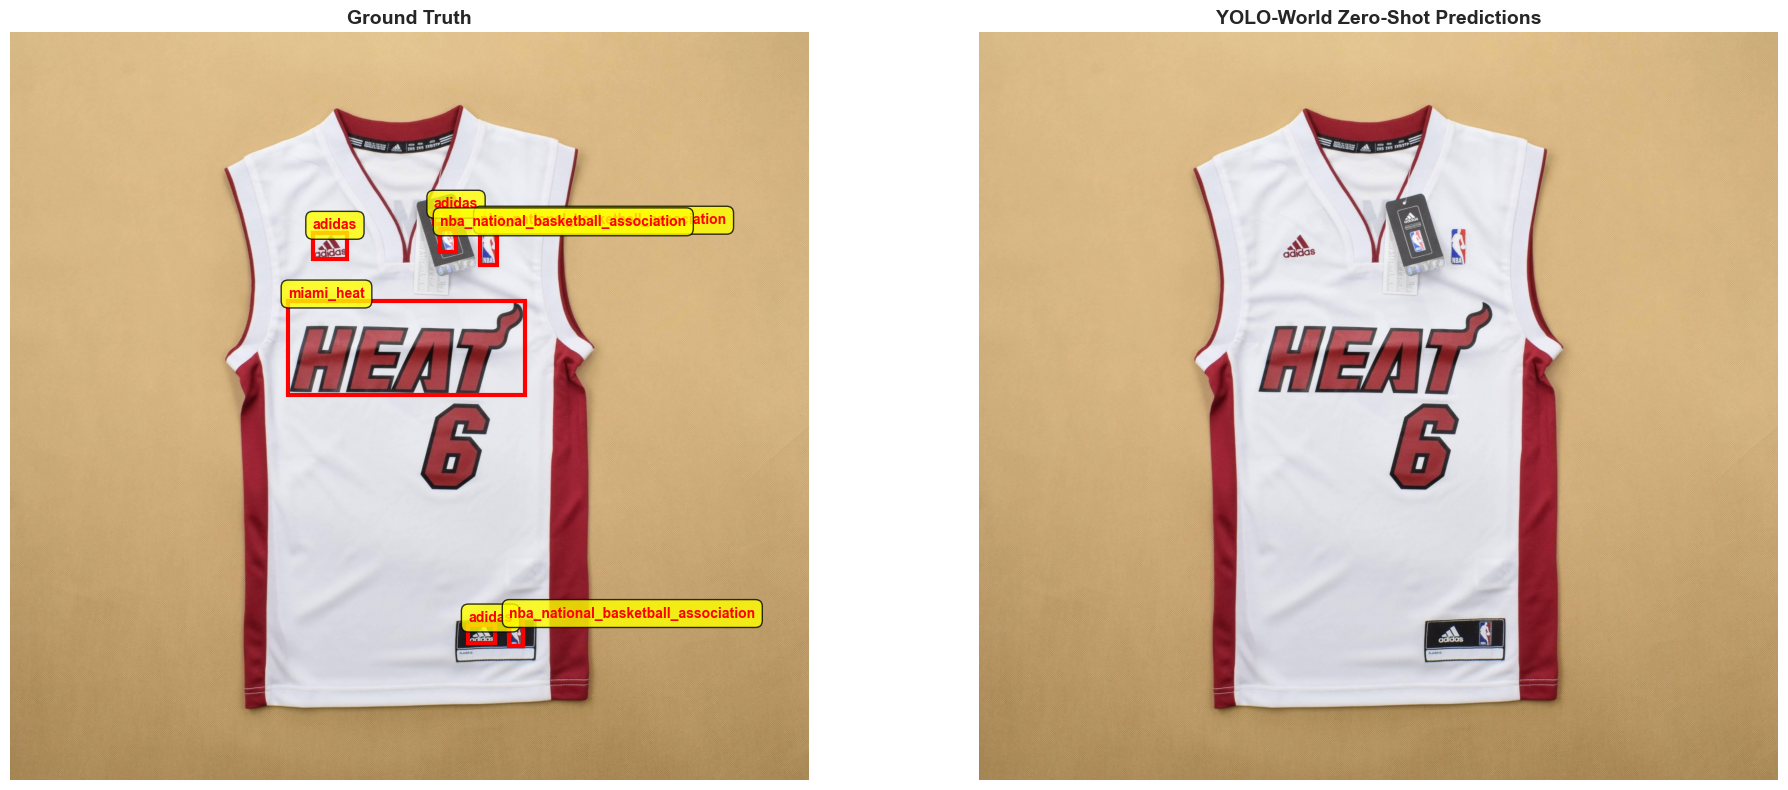


YOLO-World predictions saved to section2_yolo_world_predictions.png


In [5]:
# Run zero-shot detection
print("Running YOLO-World zero-shot detection...")
print(f"Looking for: {custom_vocabulary}")

# Predict with custom prompts
predictions = model.predict(
    source=str(section2_image),
    conf=0.25,  # Lower confidence for zero-shot
    iou=0.45,
    save=False,
    show=False,
    verbose=True
)

pred = predictions[0]

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ground truth
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title('Ground Truth', fontsize=14, fontweight='bold')

img_width, img_height = img.size
for ann in annotations:
    parts = ann.strip().split()
    if len(parts) >= 5:
        class_name = parts[0]
        x_center, y_center, width, height = [float(x) for x in parts[1:5]]
        x = (x_center - width/2) * img_width
        y = (y_center - height/2) * img_height
        w = width * img_width
        h = height * img_height
        from matplotlib.patches import Rectangle
        rect = Rectangle((x, y), w, h, linewidth=3, edgecolor='red', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(x, y-10, class_name, color='red', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

# YOLO-World predictions
axes[1].imshow(img)
axes[1].axis('off')
axes[1].set_title('YOLO-World Zero-Shot Predictions', fontsize=14, fontweight='bold')

if pred.boxes is not None and len(pred.boxes) > 0:
    boxes = pred.boxes.xyxy.cpu().numpy()
    confidences = pred.boxes.conf.cpu().numpy()
    classes = pred.boxes.cls.cpu().numpy().astype(int)
    
    print(f"\nYOLO-World detected {len(boxes)} objects:")
    for box, conf, cls in zip(boxes, confidences, classes):
        x1, y1, x2, y2 = box
        # Get class name (may need to map from class index)
        if hasattr(pred, 'names') and cls in pred.names:
            class_name = pred.names[cls]
        else:
            class_name = f"class_{cls}"
        
        print(f"  {class_name}: {conf:.3f}")
        
        from matplotlib.patches import Rectangle
        rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, 
                        edgecolor='blue', facecolor='none')
        axes[1].add_patch(rect)
        axes[1].text(x1, y1-5, f"{class_name} {conf:.2f}", 
                    color='blue', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='cyan', alpha=0.7))
else:
    print("\nNo objects detected by YOLO-World")

plt.tight_layout()
plt.savefig('section2_yolo_world_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nYOLO-World predictions saved to section2_yolo_world_predictions.png")


## 4. Analysis and Results


In [6]:
# Save results
yolo_world_results = {
    'new_classes': new_classes,
    'custom_vocabulary': custom_vocabulary,
    'num_detections': len(pred.boxes) if pred.boxes is not None else 0,
    'model_type': 'YOLO-World',
    'zero_shot': True
}

with open('section2_yolo_world_results.json', 'w') as f:
    json.dump(yolo_world_results, f, indent=2)

print("="*60)
print("YOLO-WORLD RESULTS")
print("="*60)
print(f"Target classes: {new_classes}")
print(f"Detections: {yolo_world_results['num_detections']}")
print(f"\nAdvantages:")
print("  - Zero-shot detection (no training needed)")
print("  - Works with text descriptions")
print("  - Fast inference")
print(f"\nLimitations:")
print("  - May require specific model version")
print("  - Performance depends on vocabulary quality")
print("  - May not match fine-tuned models in accuracy")
print("="*60)

print("\nYOLO-World results saved to section2_yolo_world_results.json")


YOLO-WORLD RESULTS
Target classes: ['adidas', 'nba_national_basketball_association', 'miami_heat']
Detections: 0

Advantages:
  - Zero-shot detection (no training needed)
  - Works with text descriptions
  - Fast inference

Limitations:
  - May require specific model version
  - Performance depends on vocabulary quality
  - May not match fine-tuned models in accuracy

YOLO-World results saved to section2_yolo_world_results.json
